In [36]:
# necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns

In [37]:
# Load dataset
data = pd.read_csv('dataset_small.csv')
X, y = data.iloc[:, :-1], data.iloc[:, -1]

# Replace all null or missing values with 0 (aka zero imputation)
data.fillna(0, inplace=True)

# Remove features that have the same value / constant values for a feature
selector = VarianceThreshold()
X = selector.fit_transform(data.iloc[:, :-1])
selected_columns = data.columns[:-1][selector.get_support()]
X = pd.DataFrame(X, columns=selected_columns)
y = data.iloc[:, -1]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [38]:
# Get some baseline accuracy data
baseline_clf = RandomForestClassifier(random_state=42)
baseline_clf.fit(X_train, y_train)
baseline_accuracy = accuracy_score(y_test, baseline_clf.predict(X_test))

print(f"Baseline Accuracy: {baseline_accuracy}")


Baseline Accuracy: 0.958281232238263


In [43]:
# can we improve by looking at only the top k features?

# found k by trial and error 
# k 32 = 89.9%
# k 33 = 90.2%
# k 34 = 90.4%
# k 35 = 93.7%
top_k_features = 35

# Select the top K features using SelectKBest
X_new = SelectKBest(f_classif, k=top_k_features).fit_transform(X_train, y_train)

# Set up an empty model, 42 is a random number seed to ensure reproducability
clf = RandomForestClassifier(random_state=42)

# Train it
clf.fit(X_new, y_train)

# Transform the test data to the top K features
selector = SelectKBest(f_classif, k=top_k_features).fit(X_train, y_train)
X_test_new = selector.transform(X_test)

# Test the model
y_pred = clf.predict(X_test_new)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Get feature importances
importances = clf.feature_importances_
feature_names = X_train.columns

# Pair feature names with their importances
feature_importances = zip(feature_names, importances)

# Sort features based on their importances
sorted_feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Print features and their importances
print("\nFeature Importances (sorted):")
for feature, importance in sorted_feature_importances:
    importance_value = importance * 100
    print(f"{feature}: {importance_value:.4f}%")
    
# Unzip the sorted pairs
sorted_features, sorted_importances = zip(*sorted_feature_importances)

Accuracy: 0.9173013527338866

Feature Importances (sorted):
qty_and_directory: 23.0839%
qty_tld_url: 17.1404%
qty_hyphen_url: 11.2093%
qty_dot_url: 5.6070%
qty_questionmark_url: 3.0650%
qty_dot_domain: 2.8942%
domain_in_ip: 2.5890%
qty_vowels_domain: 2.2420%
qty_asterisk_url: 2.2347%
qty_space_url: 2.1996%
qty_at_url: 2.1987%
qty_slash_url: 1.8887%
server_client_domain: 1.7290%
length_url: 1.7116%
qty_dollar_url: 1.7083%
qty_hashtag_url: 1.7070%
qty_at_domain: 1.7061%
qty_underline_url: 1.6337%
qty_and_url: 1.3636%
qty_hyphen_directory: 1.3403%
qty_dot_directory: 1.3291%
qty_underline_directory: 1.3141%
qty_at_directory: 1.2838%
qty_slash_directory: 0.9047%
qty_exclamation_url: 0.8706%
qty_percent_url: 0.8586%
qty_equal_url: 0.8583%
qty_hyphen_domain: 0.6467%
domain_length: 0.4804%
qty_comma_url: 0.4695%
qty_plus_url: 0.4514%
qty_underline_domain: 0.4323%
qty_questionmark_directory: 0.4248%
qty_tilde_url: 0.4235%
qty_equal_directory: 0.0000%


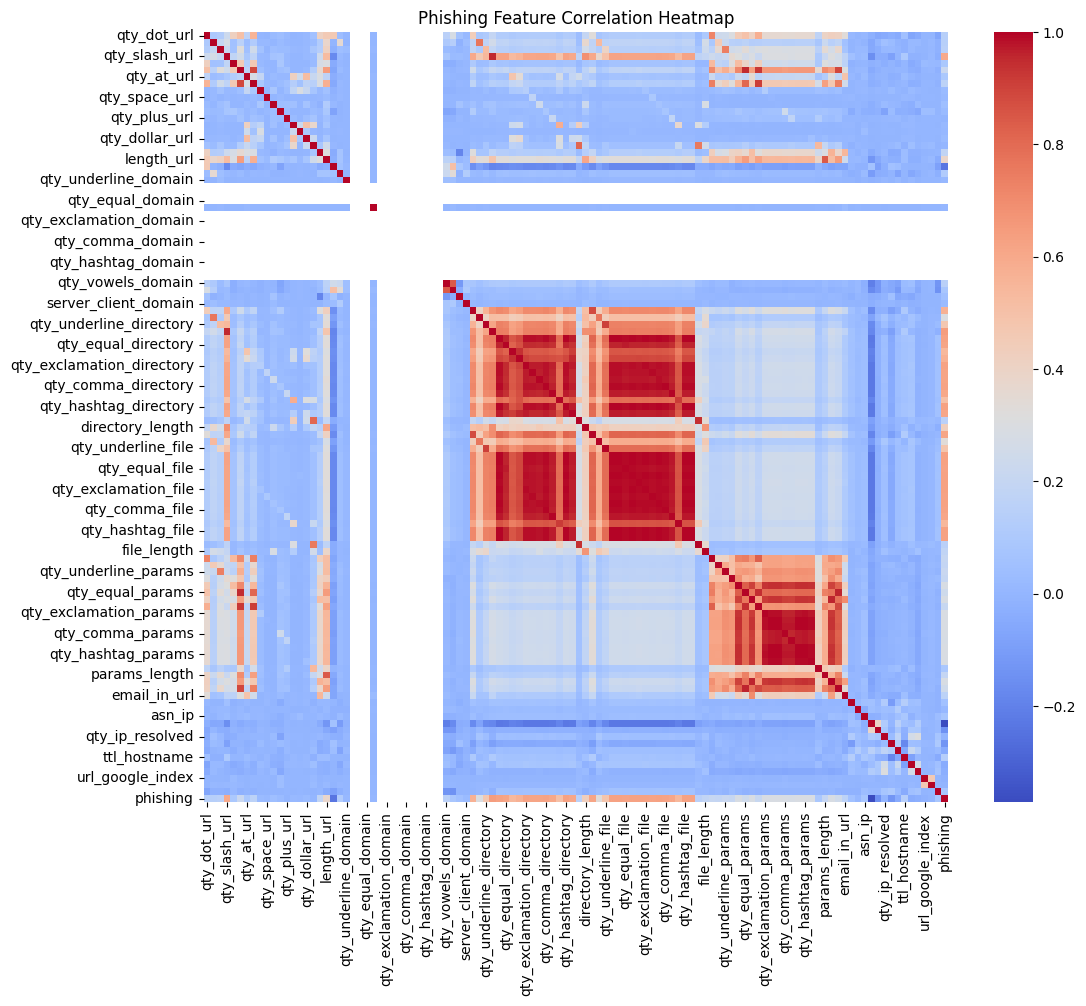

In [40]:
# Compute the correlation matrix
corr = data.corr()

# Draw the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm')
plt.title('Phishing Feature Correlation Heatmap')
plt.show()

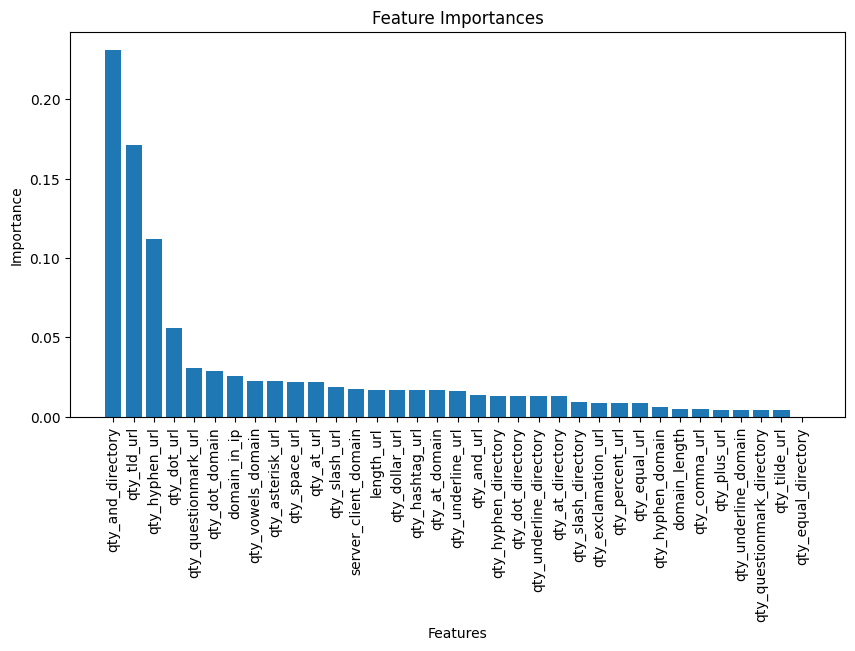

In [41]:
# Plot feature importances
plt.figure(figsize=(10, 5))
plt.bar(sorted_features, sorted_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.show()

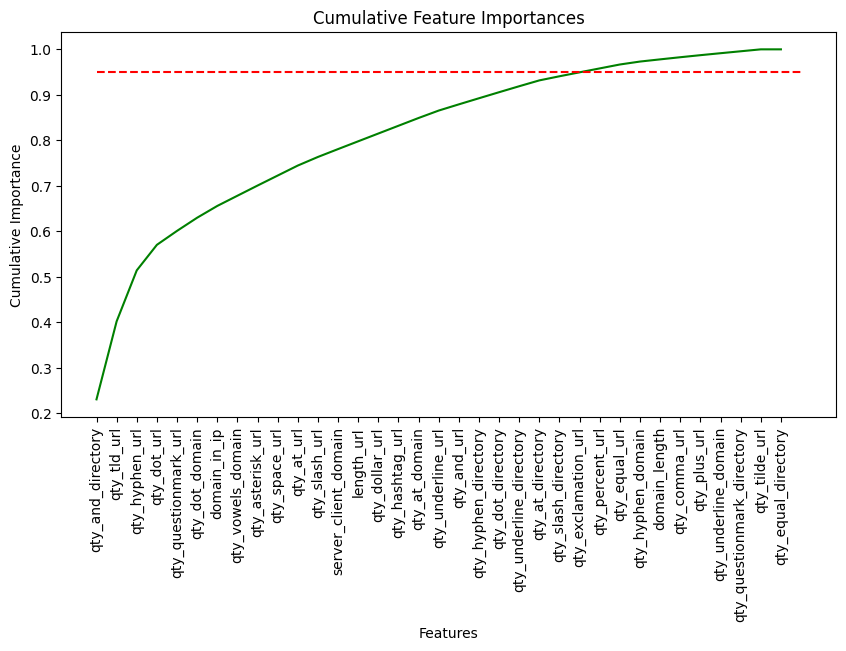

In [42]:
# Plot cumulative feature importances
cumulative_importances = np.cumsum(sorted_importances)
plt.figure(figsize=(10, 5))
plt.plot(sorted_features, cumulative_importances, 'g-')
plt.hlines(y=0.95, xmin=0, xmax=len(sorted_importances), colors='r', linestyles='dashed')
plt.xlabel('Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importances')
plt.xticks(rotation=90)
plt.show()

In [46]:
# can we improve random forest performancy by using hyperparameters and fine tuning the model?

# This is very cool! It will attempt test permutations of these options to find the best set of parameters
# This is how the search was originally performed
# It took 13 minutes on my machine to find the best set of parameters


#param_grid = {
#   'n_estimators': [10, 50, 100],
#   'max_features': ['auto', 'sqrt'],
#   'max_depth': [None, 10, 20, 30],
#   'min_samples_split': [2, 5, 10],
#   'min_samples_leaf': [1, 2, 4],
#   'bootstrap': [True, False]
#}

best_param_grid = {
    'n_estimators': [100],
    'max_features': ['sqrt'],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [False]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=best_param_grid,
                           cv=3,
                           verbose=2,
                           n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

# Train the model using the best parameters
best_clf = RandomForestClassifier(**best_params, random_state=42)
best_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = best_clf.predict(X_test)

# Evaluate the performance
tuned_accuracy = accuracy_score(y_test, y_pred)
tuned_accuracy_value = tuned_accuracy * 100
print(f"Accuracy: {tuned_accuracy_value:.4f}%")


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\mark\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\mark\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy: 95.9020%
